# Neural Collapse and Data Distillatioin

This notebook implements data distillation with neural collapse by only one step. The main papers considered here are https://github.com/SsnL/dataset-distillation and https://github.com/tding1/Neural-Collapse. The neural network is firstly trained to its terminal phase and then distills synthesized data as introduced. Below we configure our path to the dataset distillation packages from https://github.com/SsnL/dataset-distillation.

# Import

In [1]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/My Drive/
    !git clone https://github.com/SzYang721/DD-NC.git
    %cd /content/drive/My Drive/DD-NC
    !git config --global user.email "yangsongze2008@gmail.com"
    !git config --global user.name "SzYang721"
    sys.path.append('/content/drive/My Drive/DD-NC/')
    sys.path.append('/content/drive/My Drive/model_weights/')
    print("Environment setup complete.")

In [2]:
# !pip install --upgrade wandb
import wandb
wandb.login()

wandb: Currently logged in as: yangsongze2008 (data-distillation-with-nc). Use `wandb login --relogin` to force relogin


True

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
import torch.nn.functional as F

import numpy as np
import pickle
import scipy.linalg as scilin

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from torchsummary import summary

Let's import the file from the https://github.com/tding1/Neural-Collapse.

In [4]:
import models
from models import resnet_decode
from models.res_adapt import ResNet18_adapt
from utils import *

from train_encoder import train
from validate_NC import *

from validate_NC import compute_Wh_b_relation, compute_W_H_relation, compute_ETF, compute_Sigma_B, compute_Sigma_W, compute_info, FCFeatures
from data.datasets import make_dataset
from data.data_loading import get_cifar10_data_loaders
from arg_loader import *
import time

# Load Parameters

In [5]:
# architecture params
encoder='resnet18'
bias=True
ETF_fc=True
fixdim=10
SOTA=False

# MLP settings (only when using mlp and res_adapt(in which case only width has effect))
width=1024
depth=6

# hardware settings
gpu_id=1
seed=6
use_cudnn=True

# dataset
dataset='cifar10'
data_dir='~/data'
uid="Resnet18-design-SGD"
force=True

# learning options
epochs = 200
batch_size = 64
loss = 'CrossEntropy'
sample_size = None

# optimization
lr=0.001
history_size=10
optimizer = "Adam"
patience = 40

## Check the best device on machine
check = False

Determine the best device to run on: CUDA, MPS (Apple Silicon GPU), or CPU

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(gpu_id))
    device_name = torch.cuda.get_device_name(0)
    # 
    torch.cuda.empty_cache()
    if check:
        torch.cuda.memory_allocated()
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"Using device: {device}, {device_name}")

Using device: cuda:1, NVIDIA TITAN V


In [7]:
args = train_args(model=encoder,bias=bias,ETF_fc=ETF_fc,fixdim=fixdim,SOTA=SOTA,
                  width=width,depth=depth,
                  gpu_id=gpu_id,seed=seed,use_cudnn=use_cudnn,
                  dataset=dataset,data_dir=data_dir,uid=uid,force=force,
                  epochs=epochs,batch_size = batch_size,loss = loss,sample_size=sample_size,
                  lr = lr,optimizer=optimizer, patience = patience,
                  device = device)

override this uidResnet18-design-SGD
cudnn is used


# Load Dataset

In [8]:
trainloader, testloader, num_classes = make_dataset(dataset, 
                                           data_dir, 
                                           batch_size, 
                                           SOTA=SOTA)
images, labels = next(iter(trainloader))
size_train, channels, height, width = images.shape
input_size = height, width, channels
print("The number of class in our training set is ", num_classes)
print("Batch size: %d | Input size: %s" % (size_train,input_size))

Dataset: CIFAR10.
Files already downloaded and verified
Files already downloaded and verified
The number of class in our training set is  10
Batch size: 64 | Input size: (32, 32, 3)


In [9]:
# trainloader, testloader, traindataset, testdataset = get_cifar10_data_loaders(download=True, batch_size=BATCH_SIZE, num_workers=WORKERS)

# Load Model

In [10]:
if args.model == "MLP":
    Encoder = models.__dict__[args.model](hidden = args.width, depth = args.depth, fc_bias=args.bias, num_classes=num_classes).to(args.device)
elif args.model == "ResNet18_adapt":
    Encoder = ResNet18_adapt(width = args.width, num_classes=num_classes, fc_bias=args.bias).to(args.device)
else:
    Encoder = models.__dict__[args.model](num_classes=num_classes, fc_bias=args.bias, ETF_fc=args.ETF_fc, fixdim=args.fixdim, SOTA=args.SOTA).to(args.device)

print('# of model parameters: ' + str(count_network_parameters(Encoder)))
print(type(Encoder))

# of model parameters: 8867442
<class 'models.resnet.ResNet'>


In [11]:
# summary(Encoder.to("cpu"), input_size=(3, 32, 32), device = "cpu")

In [12]:
# batch_size = 64
# channels = 3
# height = 32
# width = 32

# # Creating a dummy tensor
# x_original = torch.randn(batch_size, channels, height, width).to(device)
# print(x_original.shape)
# print(x_original.device)

In [13]:
# activation = {}
# def get_activation(name):
#     def hook(model, input, output):
#         activation[name] = output.detach()
#     return hook

# model.conv1.register_forward_hook(get_activation('conv1'))
# output = model(x_original)
# print(activation['conv1'].shape)

# Create a experiment on weights&biases

## Model Training

In [16]:
config = {
    # architecture params
    "model":encoder,
    "bias": bias,
    "ETF_fc":ETF_fc,
    "fixdim":fixdim,
    "SOTA":SOTA,
    
    # MLP settings (only when using mlp and res_adapt(in which case only width has effect))
    "width":width,
    "depth":depth,
    
    # hardware settings
    "gpu_id":gpu_id,
    "seed":seed,
    "use_cudnn":use_cudnn,
    
    # dataset
    "dataset":dataset,
    "data_dir":data_dir,
    "uid":uid,
    "force":force,
    
    # learning options
    "epochs": epochs,
    "batch_size":batch_size,
    "loss": loss,
    "sample_size": sample_size,
    
    # optimization
    "lr":lr,
    "optimizer":optimizer,
    "device" :device
}

run = wandb.init(
    project="DD&NC",
    notes="Resnet18 with SOTA",
    tags=["Epochs: 200","Resnet18","Adam","cifar10","SOTA"],
    config= config
)

In [15]:
# Start timer
start_time = time.time()

train(args,Encoder,trainloader)

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
elapsed_time_minutes = elapsed_time / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [ ]:
wandb.finish()

## Model Evaluating

In [13]:
# Start timer
start_time = time.time()

if 'google.colab' in sys.modules:
    load_path = "/content/drive/MyDrive/model_weights/"+args.uid+"/"
elif socket.gethostname() == "dijkstra":
    load_path = '/data5/model_weights/'+args.uid+"/"
else:
    load_path = "./model_weights/"+args.uid+"/"

evaluate_NC(args,load_path,Encoder,trainloader,testloader,nearest_neighbor=True)

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
elapsed_time_minutes = elapsed_time / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [14]:
wandb.finish()

# Validation of Neural Collapse

Neural collapse, emerged in the terminal phase of training(TPT), let us understand the behavior of a special class of neural network, deep classifier neural network. It has widely observed in a number of data set and model structures. Is has mainly 4 fold of meaning:

- **(NC1)** Cross-example within-class variability of last-layer training activations collapses to zero, as the individual activations themselves collapse to their class means. 

- **(NC2)** The class means collapse to the vertices of a simplex equiangular tight frame (ETF). 

- **(NC3)** Up to rescaling, the last-layer classifiers collapse to the class means or in other words, to the simplex ETF (i.e., to a self-dual configuration). 

- **(NC4)** For a given activation, the classifier’s decision collapses to simply choosing whichever class has the closest train class mean (i.e., the nearest class center decision rule).

Let's denote the last linear layer as, which is also known as unconstrained feature model:

$$
h = \phi_\theta(x) \in R^{d \times n}
$$

The output of the neural network as:

$$
\Phi_\Theta(x) = W_Lh+b_L
$$

Denote $N = nk, H = [h_{1,1},..., h_{k,n}] \in R^{d \times N}$, so that the last layer can be written as $R^d \rightarrow R^k$. Also, let's denote the within-class and between-class covariance matrices as $\Sigma_W$ and $\Sigma_B$.

In general, neural collapse can be written in summary as:

$$
\Sigma_W \rightarrow 0, \\
H \rightarrow \bar{H} \rightarrow ETF, W \rightarrow \bar{H}
$$

We can measure the NC in 4 metrics:

$$
NC_1:=\frac{1}{K}trace(\Sigma_W\Sigma_B^{+})\\
NC_2:= ||\frac{WW^T}{||WW^T||_F}-\frac{1}{\sqrt{K-1}} (I_K - \frac{1}{K}1_K1_K^T)||_F\\
NC_3:= ||\frac{W\bar{H}^T}{||W\bar{H}^T||_F}-\frac{1}{\sqrt{K-1}} (I_K - \frac{1}{K}1_K1_K^T)||_F\\
NC_4:=||b+Wh_G||_2
$$

The $NC_4$ follows the simplified rule: $Wh_{k,i}+b = W(h_{k,i} - h_G) + Wh_G +b$, and $Wh_G +b$ should be 0 in the TPT.

## Find the ETF center

Let's introduce the global mean and class mean of the last-layer features ${h_{k,i}}$ as:

$$
h_G = \frac{1}{nK}\sum^{K}_{k=1}\sum^{n}_{i=1}h_{k,i}, \ \bar{h_k} = \frac{1}{n}\sum_{i=1}^{n}h_{k,i}(1\leq k \leq K)
$$

The ETF center of the last layer features, or the centered class-mean matrix,: $\bar{H} = [\bar{h_{1}} - h_G,..., \bar{h_{K}} - h_G]$. 


## Visualization of K-ETF

A (K-Simplex ETF) is a collection of points in $R^K$ specified by the columns of:

$$
M = \sqrt\frac{K}{K-1} (I_K - \frac{1}{K}1_K1_K^T)
$$

where $I_K \in R^{K \times K}$ is the identity matrix, and 1K ∈ RK is the all ones vector. In the other words, we also have

$$
M^TM = MM^T =\frac{K}{K − 1}(I_K −\frac{1}{K}1_K1_K^T)
$$

However, the learned features of neural network is often up to some scaling and rotation, thus we consider the general ETF as a collection of points in $R^d$ specified by the columns of $\sqrt\frac{K}{K-1} P (I_K −\frac{1}{K}1_K1_K^T)$, where $P \in R{d \times K} (d \leq K)$ is a orthonormal matrix, i.e., $P^TP = I_K$.

### Further Explaination

The neural collapse shows that as training proceeds, last-layer features $H$ collapse onto their class means ($NC1$), class means converge to the vertices of the simplex ETF ($NC2$), and the linear classifiers $W$ approach their corresponding class means ($NC3$). 

In the collapse stage, the $NC2$ says that the class-means centered at their global means form a Simplex Equiangular Tight Frame - or Simplex ETF. More specifically, the weigths matrix $W^{*T} \in R^{d \times d}$ with $U^TU = I_d$, the normalised matrix $M:=\frac{1}{w^*}UW^{*T}$

$$
M^TM = \frac{K}{K-1} (I_K - \frac{1}{K}1_K1_K^T)
$$

Depending on whether to fix the output dimension, we will get shapeful $W \in R^{k \times d}$ and $H \in R^{d \times N}$. The dimension of bias in the last linear layer is always fixed at $b \in R^{k \times N}$. Define $N=nk$ and k is the number of classes and n is the number of images (input data) in each class.

If we fixed the $W$, it is easy to show that the class means will converge to a standard K-ETF.

In [11]:
def k_etf(K=10):
    constant = torch.sqrt(torch.tensor(K/(K-1)))
    ETF = (torch.eye(K)-(1/K)*torch.ones((K, K)))
    return constant*ETF

def k_etf_normalize(etf):
    K = etf.shape[1]
    norm = torch.sqrt((1/K*torch.norm(etf, 'fro')**2))
    return etf/norm

def k_etf_colunm_norm(etf):
    return torch.sqrt(torch.sum(torch.square(etf), axis=0))

In [12]:
print(k_etf(K=10))

print(k_etf_colunm_norm(k_etf_normalize(k_etf(K=10))))

tensor([[ 0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
          0.9487, -0.1054],
        [-0.1054, -

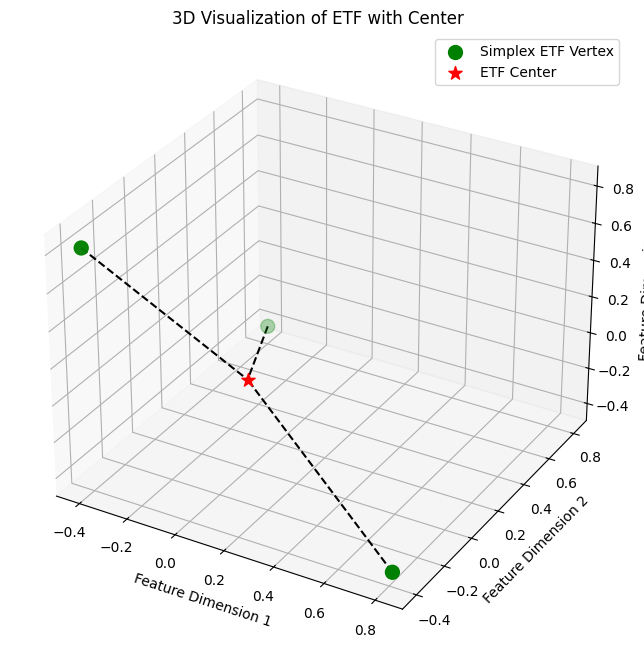

In [13]:
# Step 1: Generate the ETF matrix (as a PyTorch tensor)
simplex_vertices = k_etf(3)

# Step 2: Calculate the ETF center with PyTorch
etf_center = torch.mean(simplex_vertices, dim=0)

# Step 3: Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Convert PyTorch tensors to numpy arrays for plotting
simplex_vertices_np = simplex_vertices.numpy()
etf_center_np = etf_center.numpy()

# Plotting simplex ETF vertices
ax.scatter(simplex_vertices_np[:, 0], simplex_vertices_np[:, 1], simplex_vertices_np[:, 2], color='green', s=100, marker='o', label='Simplex ETF Vertex')

# Plotting the ETF center
ax.scatter(etf_center_np[0], etf_center_np[1], etf_center_np[2], color='red', s=100, marker='*', label='ETF Center')

# Drawing lines from each vertex to the ETF center
for vertex in simplex_vertices_np:
    ax.plot([vertex[0], etf_center_np[0]], [vertex[1], etf_center_np[1]], [vertex[2], etf_center_np[2]], 'k--')

# Labels and legend
ax.set_xlabel('Feature Dimension 1')
ax.set_ylabel('Feature Dimension 2')
ax.set_zlabel('Feature Dimension 3')
plt.title('3D Visualization of ETF with Center')
ax.legend()

plt.show()

## Analysis of Features

The improved neural network design shows us that we can fix the weight matrix $W$ as standard K-ETF and set the feature dimension $d$ equal to $k$, the number of class. We can plot this ETF and see if it matches.

In [14]:
if 'google.colab' in sys.modules:
    load_path = "/content/drive/MyDrive/model_weights/"+args.uid+"/"
elif socket.gethostname() == "dijkstra":
    load_path = '/data5/model_weights/'+args.uid+"/"
else:
    load_path = "./model_weights/"+args.uid+"/"

Encoder = Encoder.to(device)

fc_features = FCFeatures()
Encoder.fc.register_forward_pre_hook(fc_features)

print('--------------------- Evaluating -------------------------------')

### investigate a specific epochs
i = 199
###

map_location=torch.device(args.device)
Encoder.load_state_dict(torch.load(load_path + 'epoch_' + str(i + 1).zfill(3) + '.pth',map_location=map_location))

Encoder.eval()

for n, p in Encoder.named_parameters():
    if 'fc.weight' in n:
        W = p
    if 'fc.bias' in n:
        b = p
        
W = W.to(device)
b = b.to(device)

print("W is", W)
print("The shape of our weigths in this epochs is ", W.shape)

--------------------- Evaluating -------------------------------
W is Parameter containing:
tensor([[ 0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487, -0.1054,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054, -0.1054,  0.9487,
         -0.1054, -0.1054],
        [-0.1054, -0.1054, -0.1054, 

In [15]:
mu_G_train, mu_c_dict_train, train_acc1, train_acc5 = compute_info(args, Encoder, fc_features, trainloader, isTrain=True)
mu_G_test, mu_c_dict_test, test_acc1, test_acc5 = compute_info(args, Encoder, fc_features, testloader, isTrain=False)
print('[epoch: %d] | train top1: %.4f | train top5: %.4f | test top1: %.4f | test top5: %.4f ' %
      (i + 1, train_acc1, train_acc5, test_acc1, test_acc5))

_, H = compute_W_H_relation(W, mu_c_dict_train, mu_G_train)

print(H)
# print(k_etf_normalize(H))
# print("the colmun norm of unnormalised centered features is ", k_etf_colunm_norm(H))
# print("the colmun norm of normalised centered features is ",k_etf_colunm_norm(k_etf_normalize(H)))

[epoch: 200] | train top1: 99.9980 | train top5: 99.9980 | test top1: 77.7000 | test top5: 97.4800 
tensor([[ 8.5337, -0.9773, -0.9302, -0.9273, -0.9438, -0.9646, -0.9687, -0.9729,
         -0.9225, -0.9265],
        [-0.8772,  7.9582, -0.8938, -0.9039, -0.9132, -0.8925, -0.8977, -0.8953,
         -0.8628, -0.8218],
        [-0.8805, -0.8569,  7.6708, -0.8290, -0.8540, -0.8404, -0.8422, -0.8561,
         -0.8557, -0.8560],
        [-0.9197, -0.9521, -0.9181,  8.2490, -0.9110, -0.8533, -0.9294, -0.8683,
         -0.9417, -0.9554],
        [-0.9063, -0.9207, -0.8731, -0.8875,  8.0344, -0.8601, -0.9059, -0.8737,
         -0.9031, -0.9041],
        [-0.9683, -1.0094, -0.9255, -0.8946, -0.8998,  8.5704, -0.9345, -0.9410,
         -0.9980, -0.9992],
        [-0.9496, -0.9634, -0.9027, -0.8913, -0.9088, -0.8792,  8.3291, -0.9389,
         -0.9555, -0.9397],
        [-0.8789, -0.8806, -0.8442, -0.8535, -0.8525, -0.8324, -0.8890,  7.8053,
         -0.8748, -0.8994],
        [-0.8522, -0.8120, -

In [16]:
_, H_test = compute_W_H_relation(W, mu_c_dict_test, mu_G_test)
print(H_test)
# print(k_etf_normalize(H_test))
# print("the colmun norm of unnormalised centered features is ", k_etf_colunm_norm(H_test))
# print("the colmun norm of normalised centered features is ",k_etf_colunm_norm(k_etf_normalize(H_test)))

tensor([[ 6.5522, -0.8259, -0.4599, -0.7481, -0.8218, -0.9067, -0.9473, -0.7902,
         -0.3968, -0.6554],
        [-0.7246,  6.5072, -0.8632, -0.7896, -0.9013, -0.8693, -0.8473, -0.8693,
         -0.5805, -0.0620],
        [-0.4731, -0.7927,  4.7334, -0.2884, -0.1793, -0.3978, -0.5128, -0.6211,
         -0.7032, -0.7651],
        [-0.7173, -0.8550, -0.3374,  4.1500, -0.3743,  0.6412, -0.3780, -0.5088,
         -0.8006, -0.8198],
        [-0.7461, -0.8680, -0.2150, -0.3449,  5.3812, -0.5107, -0.5905, -0.3915,
         -0.8766, -0.8380],
        [-0.8742, -0.9954, -0.3928,  0.6781, -0.6097,  5.0302, -0.6490, -0.3254,
         -0.9437, -0.9183],
        [-0.8904, -0.9069, -0.4271, -0.3501, -0.5456, -0.6677,  6.5295, -0.9082,
         -0.9422, -0.8912],
        [-0.7569, -0.8358, -0.6069, -0.5446, -0.2994, -0.3778, -0.7833,  5.7805,
         -0.8193, -0.7564],
        [-0.3737, -0.5969, -0.8479, -0.7646, -0.8433, -0.8575, -0.8591, -0.8664,
          6.5938, -0.5845],
        [-0.5946, -

# Data Distillation by Autoencoder

In [17]:
# architecture params
decoder='resnet18'
bias=True
ETF_fc=True
fixdim=10
SOTA=False

# MLP settings (only when using mlp and res_adapt(in which case only width has effect))
width=1024
depth=6

# hardware settings
gpu_id=1
seed=6
use_cudnn=True

# dataset
dataset='cifar10'
data_dir='~/data'
uid="Resnet18-design-SGD-decoder"
force=True

# learning options
epochs = 200
batch_size = 64
loss = 'MSE'
sample_size = None

# optimization (change for autoencoder)
lr=0.001
history_size=10
optimizer = "Adam"
patience = 40

## Check the best device on machine
check = False

In [18]:
if torch.cuda.is_available():
    device = torch.device("cuda:"+str(gpu_id))
    device_name = torch.cuda.get_device_name(0)
    # 
    torch.cuda.empty_cache()
    if check:
        torch.cuda.memory_allocated()
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    device_name = "Apple Silicon GPU"
else:
    device = torch.device("cpu")
    device_name = "CPU"

print(f"Using device: {device}, {device_name}")

Using device: cuda:1, NVIDIA TITAN V


In [19]:
auto_args = train_args(model=decoder,bias=bias,ETF_fc=ETF_fc,fixdim=fixdim,SOTA=SOTA,
                  width=width,depth=depth,
                  gpu_id=gpu_id,seed=seed,use_cudnn=use_cudnn,
                  dataset=dataset,data_dir=data_dir,uid=uid,force=force,
                  epochs=epochs,batch_size = batch_size,loss = loss,sample_size=sample_size,
                  lr = lr,optimizer=optimizer, patience = patience,
                  device = device)

override this uidResnet18-design-SGD-decoder
cudnn is used


In [34]:
if auto_args.model == "MLP":
    Decoder = models.__dict__[args.model](hidden = auto_args.width, depth = auto_args.depth, fc_bias=auto_args.bias, num_classes=num_classes).to(auto_args.device)
elif auto_args.model == "ResNet18_adapt":
    Decoder = ResNet18_adapt(width = auto_args.width, num_classes=num_classes, fc_bias=auto_args.bias).to(auto_args.device)
else:
    Decoder = resnet_decode.__dict__[auto_args.model](num_classes=num_classes, fixdim=auto_args.fixdim, SOTA=auto_args.SOTA).to(auto_args.device)

print(type(Decoder))

<class 'models.resnet_decode.ResNet'>


In [21]:
# batch_size = 64
# channels = 10
# height = 1
# width = 1

# # Creating a dummy tensor
# x_original = torch.randn(batch_size, channels, height, width).to(device)
# print(x_original.shape)
# print(x_original.device)


# Decoder(x_original)

In [35]:
# summary(Decoder.to("cpu"), input_size=(10, 1, 1), device = "cpu")

In [24]:
# for dname, dparameter in decoder.named_parameters():
#     print(f"{dname}: {dparameter.numel()} parameters")

In [26]:
from models.AE import Autoencoder

In [27]:
autoencoder = Autoencoder(Encoder,Decoder)

In [28]:
autoencoder.freeze_encoder()
autoencoder.unfreeze_decoder()
print('# of model parameters: ' + str(count_network_parameters(autoencoder)))
print(type(autoencoder))

# of model parameters: 8904554
<class 'models.AE.Autoencoder'>


## Create a experiment on weights&biases

In [29]:
from train_AE import AE_train

In [30]:
config = {
    # architecture params
    "model":decoder,
    "bias": bias,
    "ETF_fc":ETF_fc,
    "fixdim":fixdim,
    "SOTA":SOTA,
    
    # MLP settings (only when using mlp and res_adapt(in which case only width has effect))
    "width":width,
    "depth":depth,
    
    # hardware settings
    "gpu_id":gpu_id,
    "seed":seed,
    "use_cudnn":use_cudnn,
    
    # dataset
    "dataset":dataset,
    "data_dir":data_dir,
    "uid":uid,
    "force":force,
    
    # learning options
    "epochs": epochs,
    "batch_size":batch_size,
    "loss": loss,
    "sample_size": sample_size,
    
    # optimization
    "lr":lr,
    "optimizer":optimizer,
    "device" :device
}

run = wandb.init(
    project="DD&NC",
    notes="Undesigned Autoencoder",
    tags=["Epochs: 200","Resnet18","Adam","cifar10","SOTA"],
    config= config
)

# of model parameters: 8904554
--------------------- Training -------------------------------

Training Epoch: [1 | 200] LR: 0.001000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


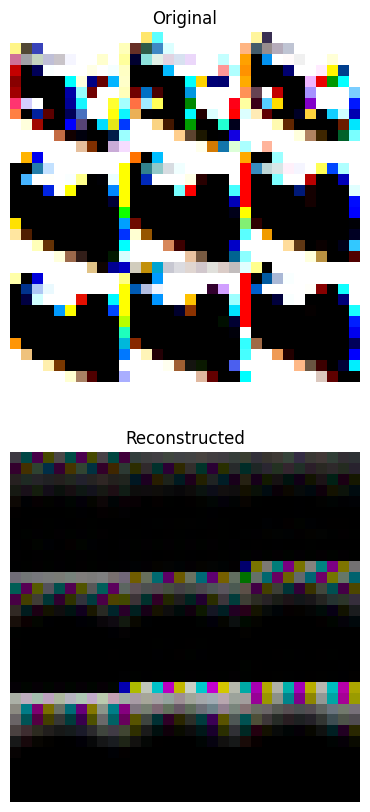

[epoch: 1] (782/782) | Loss: 1.5044 |

Training Epoch: [2 | 200] LR: 0.001000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


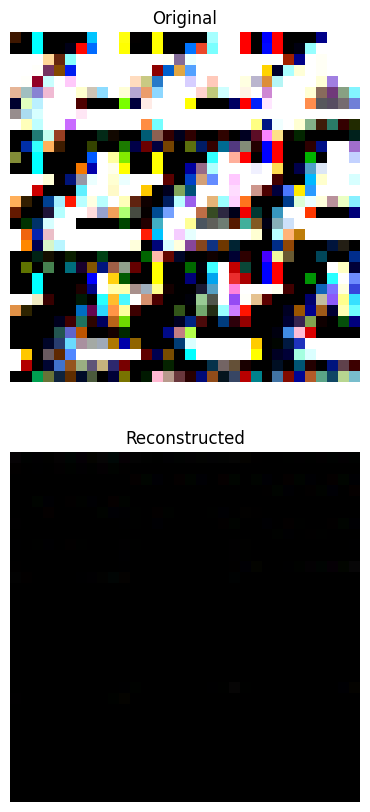

[epoch: 2] (782/782) | Loss: 1.5002 |

Training Epoch: [3 | 200] LR: 0.001000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


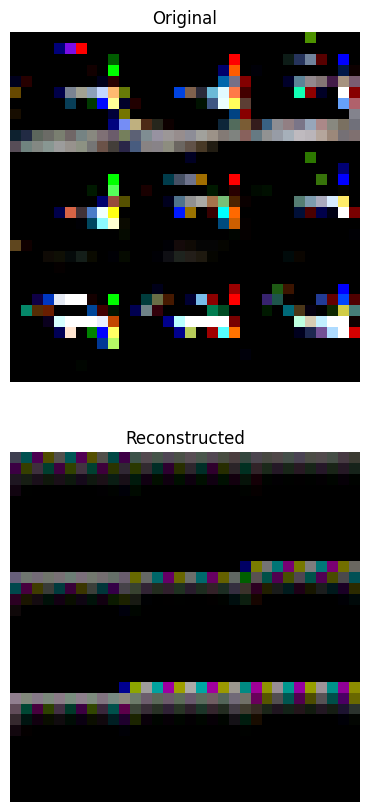

[epoch: 3] (782/782) | Loss: 1.4967 |

Training Epoch: [4 | 200] LR: 0.001000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


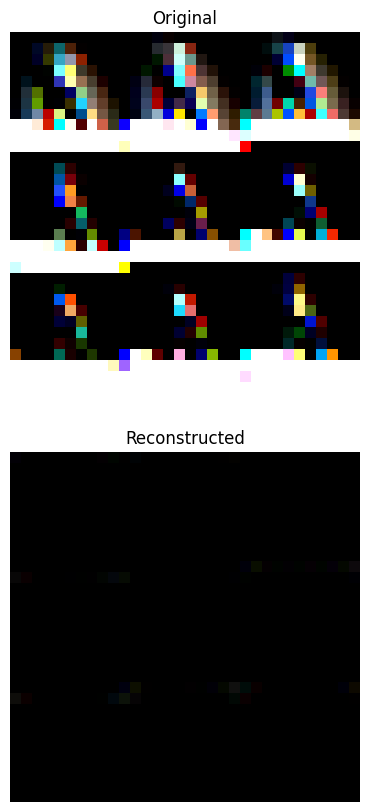

[epoch: 4] (782/782) | Loss: 1.4946 |

Training Epoch: [5 | 200] LR: 0.001000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


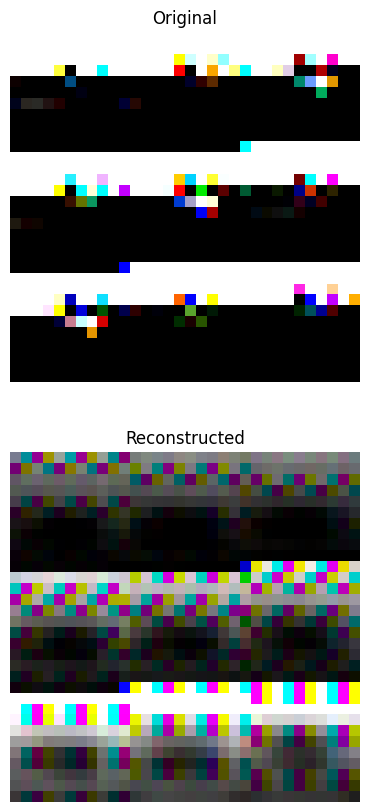

[epoch: 5] (782/782) | Loss: 1.4935 |

Training Epoch: [6 | 200] LR: 0.001000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


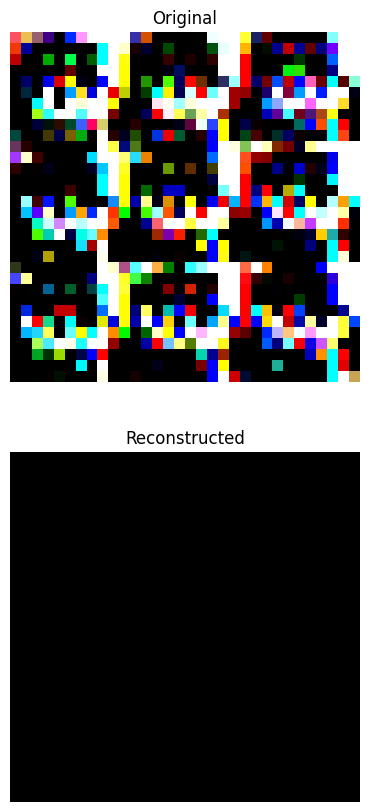

[epoch: 6] (782/782) | Loss: 1.4930 |

Training Epoch: [7 | 200] LR: 0.001000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


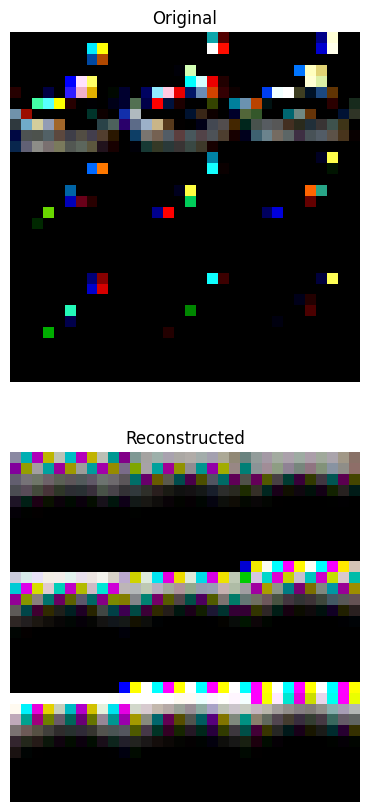

[epoch: 7] (782/782) | Loss: 1.4924 |

Training Epoch: [8 | 200] LR: 0.001000


KeyboardInterrupt: 

In [31]:
# Start timer
start_time = time.time()

AE_train(auto_args,autoencoder,trainloader,visualize=True)

# End timer
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
elapsed_time_minutes = elapsed_time / 60
print(f"Elapsed time: {elapsed_time_minutes:.2f} minutes")

In [32]:
wandb.finish()

LR,▁▁▁▁▁▁▁
losses.avg,█▆▄▂▂▁▁
LR,0.001
losses.avg,1.49235
